# NMF Model Workflow
### This notebook is to represent the entire workflow of a model from:
1. Imports
2. Data Importing
    * Import training data from parquet files
    * Select desired run and lumisections
3. Data Preprocessing
    * Remove cross
    * Normalization?
4. Model Training
    * TODO: Training loss graph?
5. Model Testing
    * Import testing data from parquet files
    * Select desired run and lumisections
    * Remove Cross
    * Predict on testing data
6. Data Postprocessing
    * Add cross back
    * Analyze the binary loss for anomalies
    * Plot testing data, prediction, loss, and binary loss

# 1. <u>Imports

In [1]:
%%time
# imports

import os
import sys
import json
import joblib
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# thisdir = os.getcwd()
# topdir = os.path.abspath(os.path.join(thisdir, '../../../'))
# sys.path.append(topdir)

# import tools.iotools as iotools
# import tools.dftools as dftools
import plottools as plottools
importlib.reload(plottools);
# from tools.dataloadertools import MEDataLoader

# from studies.clusters_2024.preprocessing.preprocessor import make_default_preprocessor
# from studies.clusters_2024.nmf.modeldefs.nmf2d 
from nmf2d import NMF2D
# from studies.clusters_2024.nmf.nmf_training import find_files, train

import functions
importlib.reload(functions);
from functions import *
# from functions import save_digis_png
# from functions import extract_data_2d
# #from functions import extract_data_2d_multi_lumis
# from functions import plot_fpix_digi
# from functions import remove_cross
# from functions import add_cross
# from pyarrow.parquet import ParquetDataset
    
#Used to load an extension that can skip the remaining execution of a cell. 
#Used to skip the training so we don't constantly retrain a model
%load_ext skip_kernel_extension
%reload_ext skip_kernel_extension

optimized_powerGroupStringsList = np.array(['FPix_BmO_D3_ROG4','FPix_BmO_D2_ROG4','FPix_BmO_D1_ROG4','FPix_BmO_D3_ROG3','FPix_BmO_D2_ROG3','FPix_BmO_D1_ROG3','FPix_BmO_D3_ROG2','FPix_BmO_D2_ROG2','FPix_BmO_D1_ROG2','FPix_BmO_D3_ROG1','FPix_BmO_D2_ROG1','FPix_BmO_D1_ROG1','FPix_BmI_D3_ROG1','FPix_BmI_D2_ROG1','FPix_BmI_D1_ROG1','FPix_BmI_D3_ROG2','FPix_BmI_D2_ROG2','FPix_BmI_D1_ROG2','FPix_BmI_D3_ROG3','FPix_BmI_D2_ROG3','FPix_BmI_D1_ROG3','FPix_BmI_D3_ROG4','FPix_BmI_D2_ROG4','FPix_BmI_D1_ROG4','FPix_BpO_D1_ROG4','FPix_BpO_D2_ROG4','FPix_BpO_D3_ROG4','FPix_BpO_D1_ROG3','FPix_BpO_D2_ROG3','FPix_BpO_D3_ROG3','FPix_BpO_D1_ROG2','FPix_BpO_D2_ROG2','FPix_BpO_D3_ROG2','FPix_BpO_D1_ROG1','FPix_BpO_D2_ROG1','FPix_BpO_D3_ROG1','FPix_BpI_D1_ROG1','FPix_BpI_D2_ROG1','FPix_BpI_D3_ROG1','FPix_BpI_D1_ROG2','FPix_BpI_D2_ROG2','FPix_BpI_D3_ROG2','FPix_BpI_D1_ROG3','FPix_BpI_D2_ROG3','FPix_BpI_D3_ROG3','FPix_BpI_D1_ROG4','FPix_BpI_D2_ROG4','FPix_BpI_D3_ROG4'])
#A list of all of the quarters of the detector
QUARTERS = np.array([['FPix_BmI_D3_ROG1','FPix_BmI_D3_ROG2','FPix_BmI_D3_ROG3','FPix_BmI_D3_ROG4','FPix_BmI_D2_ROG1','FPix_BmI_D2_ROG2','FPix_BmI_D2_ROG3','FPix_BmI_D2_ROG4','FPix_BmI_D1_ROG1','FPix_BmI_D1_ROG2','FPix_BmI_D1_ROG3','FPix_BmI_D1_ROG4'], ['FPix_BmO_D3_ROG1','FPix_BmO_D3_ROG2','FPix_BmO_D3_ROG3','FPix_BmO_D3_ROG4','FPix_BmO_D2_ROG1','FPix_BmO_D2_ROG2','FPix_BmO_D2_ROG3','FPix_BmO_D2_ROG4','FPix_BmO_D1_ROG1','FPix_BmO_D1_ROG2','FPix_BmO_D1_ROG3','FPix_BmO_D1_ROG4'], ['FPix_BpI_D1_ROG1','FPix_BpI_D1_ROG2','FPix_BpI_D1_ROG3','FPix_BpI_D1_ROG4','FPix_BpI_D2_ROG1','FPix_BpI_D2_ROG2','FPix_BpI_D2_ROG3','FPix_BpI_D2_ROG4','FPix_BpI_D3_ROG1','FPix_BpI_D3_ROG2','FPix_BpI_D3_ROG3','FPix_BpI_D3_ROG4'], ['FPix_BpO_D1_ROG1','FPix_BpO_D1_ROG2','FPix_BpO_D1_ROG3','FPix_BpO_D1_ROG4','FPix_BpO_D2_ROG1','FPix_BpO_D2_ROG2','FPix_BpO_D2_ROG3','FPix_BpO_D2_ROG4','FPix_BpO_D3_ROG1','FPix_BpO_D3_ROG2','FPix_BpO_D3_ROG3','FPix_BpO_D3_ROG4']])

CPU times: user 1.89 s, sys: 1.08 s, total: 2.97 s
Wall time: 4.11 s


# 2. <ins>Data Importing

### Set path to parquet file

In [2]:
# set path to files
ERA = "C"
VERSION = 2
PART = 1
YEAR = 2025

NUM_COMPONENTS = 5

file = f'/eos/user/a/alaperto/TkDQM/Devel/NMFolder/data/ZeroBias-Run{YEAR}{ERA}-PromptReco-v{VERSION}-DQMIO-PixelPhase1-Phase1_MechanicalView-PXForward-clusters_per_SignedDiskCoord_per_SignedBladePanelCoord_PXRing_1.parquet'
oms_json = f'omsdata/omsdata_Run{YEAR}{ERA}-v{VERSION}.json'
ring_num = int(file[-9]) #The -9th character is ALWAYS the ring number for our data
era = file[63] #The 63rd character is ALWAYS the era character for our data

### Import desired run and lumisections

In [3]:
%%time

run_number = 393240
lumi_start = 39
lumi_end = 1155
#Exclude lumisections for training in the second part of 2024 Era F
# extra_filters = [('ls_number', '!=', 1348), ('ls_number', '!=', 1349), ('ls_number', '!=', 1350)]

#Exclude lumisections for training in the first part of 2025 Era C part 1. Trained on run 392642
# extra_filters = [('ls_number', '!=', 168), ('ls_number', '!=', 169), ('ls_number', '!=', 170), ('ls_number', '!=', 523), ('ls_number', '!=', 524), 
#                  ('ls_number', '!=', 525), ('ls_number', '!=', 526), ('ls_number', '!=', 573), ('ls_number', '!=', 574), ('ls_number', '!=', 575), 
#                  ('ls_number', '!=', 576), ('ls_number', '!=', 577), ('ls_number', '!=', 578), ('ls_number', '!=', 853), ('ls_number', '!=', 854), 
#                  ('ls_number', '!=', 855), ('ls_number', '!=', 856), ('ls_number', '!=', 1775),('ls_number', '!=', 1776),('ls_number', '!=', 1777), 
#                  ('ls_number', '!=', 1778), ('ls_number', '!=', 1779), #Below is an exclusion for an anomaly in FPix_BmI_D2_ROG1
#                  ('ls_number', '!=', 210), ('ls_number', '!=', 211), ('ls_number', '!=', 212), ('ls_number', '!=', 213), ('ls_number', '!=', 214), ('ls_number', '!=', 215), ('ls_number', '!=', 216), ('ls_number', '!=', 217), ('ls_number', '!=', 218), ('ls_number', '!=', 219), ('ls_number', '!=', 220), ('ls_number', '!=', 221), ('ls_number', '!=', 222), ('ls_number', '!=', 223), ('ls_number', '!=', 224), ('ls_number', '!=', 225), ('ls_number', '!=', 226), ('ls_number', '!=', 227), ('ls_number', '!=', 228), ('ls_number', '!=', 229), ('ls_number', '!=', 230), ('ls_number', '!=', 231), ('ls_number', '!=', 232), ('ls_number', '!=', 233), ('ls_number', '!=', 234), ('ls_number', '!=', 235), ('ls_number', '!=', 236), ('ls_number', '!=', 237), ('ls_number', '!=', 238), 
#                  ('ls_number', '<=', 984)] #Run ends at LS 1897 with no extra anomalies, but we only want 900LS total

#Exclude lumisections for training a third model in the first part of 2025 Era C part 1. Trained on run 392296
# extra_filters = [('ls_number', '!=', 710)]

# Exclude lumisections for training in the second part of 2025 Era C part 2. Training for run 392710
# extra_filters = [('ls_number', '!=', 329), ('ls_number', '!=', 330), ('ls_number', '!=', 331), ('ls_number', '!=', 332), ('ls_number', '!=', 904), 
#                  ('ls_number', '!=', 905), ('ls_number', '!=', 906), ('ls_number', '!=', 907), ('ls_number', '!=', 908), ('ls_number', '!=', 1086), 
#                  ('ls_number', '!=', 1087), ('ls_number', '!=', 1088), ('ls_number', '!=', 1089), ('ls_number', '!=', 1090), ('ls_number', '!=', 1091), 
#                  ('ls_number', '!=', 1346), ('ls_number', '!=', 1347), ('ls_number', '!=', 1348), ('ls_number', '!=', 1683), ('ls_number', '!=', 1684), 
#                  ('ls_number', '!=', 1685), ('ls_number', '!=', 1686),('ls_number', '!=', 1687), ('ls_number', '!=', 1688),
#                  ('ls_number', '<=', 950)] #Run ends at LS 1955 with no extra anomalies, but we only want 900LS total

#Exclude lumisections for training a third model in the second part of 2025 Era C part 2. Training for run 392925
#First AND seconds training had some weird anomalies in powergroup FPix_BpI_D3_ROG1 and FPix_BmI_D3_ROG2 respectively
#Issue in the second chosen training Run from LS484 to LS699, inclusive
extra_filters = [('ls_number', '!=', 697), ('ls_number', '!=', 698), ('ls_number', '!=', 699), 
                 ('ls_number', '<=', 1160), ('ls_number', '!=', 429), ('ls_number', '!=', 430), ('ls_number', '!=', 431), ('ls_number', '!=', 432), ('ls_number', '!=', 433), #Run ends at LS 1921 with no extra anomalies, but we only want 900LS total
                ('ls_number', '!=', 483), ('ls_number', '!=', 484), ('ls_number', '!=', 485), ('ls_number', '!=', 486), ('ls_number', '!=', 487), ('ls_number', '!=', 488), ('ls_number', '!=', 489), ('ls_number', '!=', 490), ('ls_number', '!=', 491), ('ls_number', '!=', 492), ('ls_number', '!=', 493), ('ls_number', '!=', 494), ('ls_number', '!=', 495), ('ls_number', '!=', 496), ('ls_number', '!=', 497), ('ls_number', '!=', 498), ('ls_number', '!=', 499), ('ls_number', '!=', 500), ('ls_number', '!=', 501), ('ls_number', '!=', 502), ('ls_number', '!=', 503), ('ls_number', '!=', 504), ('ls_number', '!=', 505), ('ls_number', '!=', 506), ('ls_number', '!=', 507), ('ls_number', '!=', 508), ('ls_number', '!=', 509), ('ls_number', '!=', 510), ('ls_number', '!=', 511), ('ls_number', '!=', 512), ('ls_number', '!=', 513), ('ls_number', '!=', 514), ('ls_number', '!=', 515), ('ls_number', '!=', 516), ('ls_number', '!=', 517), ('ls_number', '!=', 518), ('ls_number', '!=', 519), ('ls_number', '!=', 520), ('ls_number', '!=', 521), ('ls_number', '!=', 522), ('ls_number', '!=', 523), ('ls_number', '!=', 524), ('ls_number', '!=', 525), ('ls_number', '!=', 526), ('ls_number', '!=', 527), ('ls_number', '!=', 528), ('ls_number', '!=', 529), ('ls_number', '!=', 530), ('ls_number', '!=', 531), ('ls_number', '!=', 532), ('ls_number', '!=', 533), ('ls_number', '!=', 534), ('ls_number', '!=', 535), ('ls_number', '!=', 536), ('ls_number', '!=', 537), ('ls_number', '!=', 538), ('ls_number', '!=', 539), ('ls_number', '!=', 540), ('ls_number', '!=', 541), ('ls_number', '!=', 542), ('ls_number', '!=', 543), ('ls_number', '!=', 544), ('ls_number', '!=', 545), ('ls_number', '!=', 546), ('ls_number', '!=', 547), ('ls_number', '!=', 548), ('ls_number', '!=', 549), ('ls_number', '!=', 550), ('ls_number', '!=', 551), ('ls_number', '!=', 552), ('ls_number', '!=', 553), ('ls_number', '!=', 554), ('ls_number', '!=', 555), ('ls_number', '!=', 556), ('ls_number', '!=', 557), ('ls_number', '!=', 558), ('ls_number', '!=', 559), ('ls_number', '!=', 560), ('ls_number', '!=', 561), ('ls_number', '!=', 562), ('ls_number', '!=', 563), ('ls_number', '!=', 564), ('ls_number', '!=', 565), ('ls_number', '!=', 566), ('ls_number', '!=', 567), ('ls_number', '!=', 568), ('ls_number', '!=', 569), ('ls_number', '!=', 570), ('ls_number', '!=', 571), ('ls_number', '!=', 572), ('ls_number', '!=', 573), ('ls_number', '!=', 574), ('ls_number', '!=', 575), ('ls_number', '!=', 576), ('ls_number', '!=', 577), ('ls_number', '!=', 578), ('ls_number', '!=', 579), ('ls_number', '!=', 580), ('ls_number', '!=', 581), ('ls_number', '!=', 582), ('ls_number', '!=', 583), ('ls_number', '!=', 584), ('ls_number', '!=', 585), ('ls_number', '!=', 586), ('ls_number', '!=', 587), ('ls_number', '!=', 588), ('ls_number', '!=', 589), ('ls_number', '!=', 590), ('ls_number', '!=', 591), ('ls_number', '!=', 592), ('ls_number', '!=', 593), ('ls_number', '!=', 594), ('ls_number', '!=', 595), ('ls_number', '!=', 596), ('ls_number', '!=', 597), ('ls_number', '!=', 598), ('ls_number', '!=', 599), ('ls_number', '!=', 600), ('ls_number', '!=', 601), ('ls_number', '!=', 602), ('ls_number', '!=', 603), ('ls_number', '!=', 604), ('ls_number', '!=', 605), ('ls_number', '!=', 606), ('ls_number', '!=', 607), ('ls_number', '!=', 608), ('ls_number', '!=', 609), ('ls_number', '!=', 610), ('ls_number', '!=', 611), ('ls_number', '!=', 612), ('ls_number', '!=', 613), ('ls_number', '!=', 614), ('ls_number', '!=', 615), ('ls_number', '!=', 616), ('ls_number', '!=', 617), ('ls_number', '!=', 618), ('ls_number', '!=', 619), ('ls_number', '!=', 620), ('ls_number', '!=', 621), ('ls_number', '!=', 622), ('ls_number', '!=', 623), ('ls_number', '!=', 624), ('ls_number', '!=', 625), ('ls_number', '!=', 626), ('ls_number', '!=', 627), ('ls_number', '!=', 628), ('ls_number', '!=', 629), ('ls_number', '!=', 630), ('ls_number', '!=', 631), ('ls_number', '!=', 632), ('ls_number', '!=', 633), ('ls_number', '!=', 634), ('ls_number', '!=', 635), ('ls_number', '!=', 636), ('ls_number', '!=', 637), ('ls_number', '!=', 638), ('ls_number', '!=', 639), ('ls_number', '!=', 640), ('ls_number', '!=', 641), ('ls_number', '!=', 642), ('ls_number', '!=', 643), ('ls_number', '!=', 644), ('ls_number', '!=', 645), ('ls_number', '!=', 646), ('ls_number', '!=', 647), ('ls_number', '!=', 648), ('ls_number', '!=', 649), ('ls_number', '!=', 650), ('ls_number', '!=', 651), ('ls_number', '!=', 652), ('ls_number', '!=', 653), ('ls_number', '!=', 654), ('ls_number', '!=', 655), ('ls_number', '!=', 656), ('ls_number', '!=', 657), ('ls_number', '!=', 658), ('ls_number', '!=', 659), ('ls_number', '!=', 660), ('ls_number', '!=', 661), ('ls_number', '!=', 662), ('ls_number', '!=', 663), ('ls_number', '!=', 664), ('ls_number', '!=', 665), ('ls_number', '!=', 666), ('ls_number', '!=', 667), ('ls_number', '!=', 668), ('ls_number', '!=', 669), ('ls_number', '!=', 670), ('ls_number', '!=', 671), ('ls_number', '!=', 672), ('ls_number', '!=', 673), ('ls_number', '!=', 674), ('ls_number', '!=', 675), ('ls_number', '!=', 676), ('ls_number', '!=', 677), ('ls_number', '!=', 678), ('ls_number', '!=', 679), ('ls_number', '!=', 680), ('ls_number', '!=', 681), ('ls_number', '!=', 682), ('ls_number', '!=', 683), ('ls_number', '!=', 684), ('ls_number', '!=', 685), ('ls_number', '!=', 686), ('ls_number', '!=', 687), ('ls_number', '!=', 688), ('ls_number', '!=', 689), ('ls_number', '!=', 690), ('ls_number', '!=', 691), ('ls_number', '!=', 692), ('ls_number', '!=', 693), ('ls_number', '!=', 694), ('ls_number', '!=', 695), ('ls_number', '!=', 696), ('ls_number', '!=', 697), ('ls_number', '!=', 698), ('ls_number', '!=', 699) 
]

#Exclude lumisections for training in the first part of 2025 Era C version 2. Trained on Run 393240
extra_filters = [('ls_number', '!=', 3533), ('ls_number', '!=', 3534), ('ls_number', '!=', 3535), 
                 ('ls_number', '<=', 962)] #Run ends at LS 1921 with no extra anomalies, but we only want 900LS total

# multi_lumi_data, lumisections =  extract_data_2d_multi_lumis(file, run_number, lumi_start, lumi_end)
#Extract all of the lumisections from this run, and optionally exclude the lumisection with an anomaly
multi_lumi_data, lumisections = extract_data_2d_all_lumis(file, run_number, oms_json, extra_filters=extra_filters)
print("Multi Lumi Data WITH Cross Shape: ", multi_lumi_data.shape, "\n")
print("Extracted Lumisections: ", lumisections, "\n")

Multi Lumi Data WITH Cross Shape:  (900, 92, 56) 

Extracted Lumisections:  [ 63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290

### Import the Whole Era if Desired

In [3]:
%%time
multi_lumi_data, all_runs, lumisections, df = extract_data_whole_era(file, oms_json, extra_filters=[])
del df
all_runs, indices = np.unique(all_runs, return_index=True)
indices = indices[1:] #The first index in indices is always 0, since the first number is always unique, so we discard that. 
print(f"There are {len(all_runs)} Runs and {len(lumisections)} Lumisections that Pass All DCS Flags: \n", all_runs)

There are 31 Runs and 21618 Lumisections that Pass All DCS Flags: 
 [393111 393125 393126 393127 393128 393129 393147 393168 393169 393170
 393171 393240 393273 393274 393275 393276 393331 393346 393347 393376
 393377 393378 393445 393446 393447 393448 393461 393512 393513 393514
 393516]
CPU times: user 6.09 s, sys: 4.47 s, total: 10.6 s
Wall time: 11.6 s


#### Inspect Certain Lumisections

Index of Lumisection 709:  708


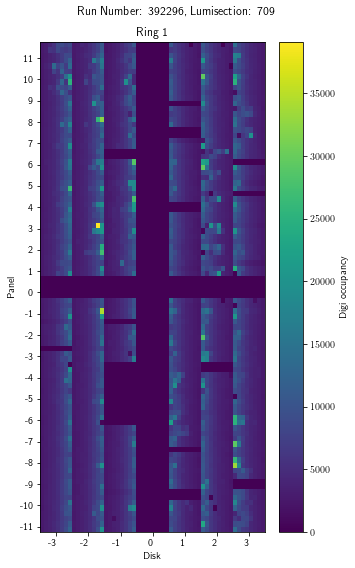

In [5]:
desired_lumi = 709
lumi_index = lumiToIndex(lumisections, desired_lumi)

print("Index of Lumisection {}: ".format(desired_lumi), lumi_index)

save_digis_png(multi_lumi_data[lumi_index], run_number, desired_lumi, ring_num)

# 3. <ins>Data Preprocessing
### Remove Cross

In [4]:
%%time
multi_lumi_data_no_cross = remove_cross(multi_lumi_data)
print("Multi Lumi Data WITHOUT Cross Shape: ", multi_lumi_data_no_cross.shape, "\n")

Multi Lumi Data WITHOUT Cross Shape:  (900, 88, 48) 

CPU times: user 20.4 ms, sys: 21 ms, total: 41.4 ms
Wall time: 40.6 ms


# 4. <ins>Model Training

### Train the Model and Plot Components

Now processing batch 1 / 30...
Now processing batch 6 / 30...
Now processing batch 11 / 30...
Now processing batch 16 / 30...
Now processing batch 21 / 30...
Now processing batch 26 / 30...
Model Shape:  [88, 48]


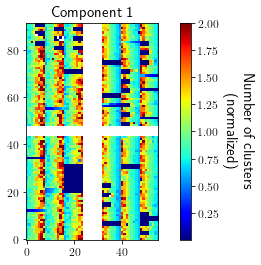

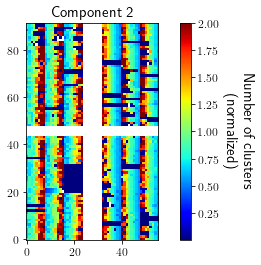

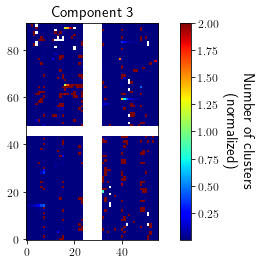

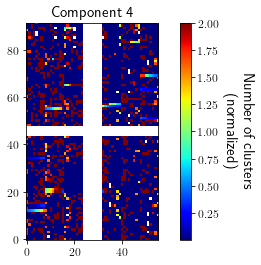

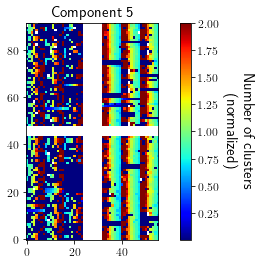

CPU times: user 13.6 s, sys: 18.5 s, total: 32.1 s
Wall time: 13.9 s


In [5]:
%%time
%%skip False
#Set True if you'd like to avoid retraining the model. 

nmfResult = None
batch_size = 3000
num_components = NUM_COMPONENTS

do_plot_components = True

# print(f'Now running on era {era}...')
# nrows = sum(dataloaders[era].nrows)
# nbatches = min(30, max(1, 3*int(nrows/batch_size)))
nbatches = 30
# print(f'Will train on {nbatches} batches of size {batch_size}.')

# make the NMF model for this era
nmf = NMF2D(n_components=num_components, forget_factor=1, batch_size=batch_size, verbose=True,
            tol=0.0, max_no_improvement=100, max_iter=1000,
            alpha_H=0.1)

# training settings
verbose = True
min_entries = 0.5e6
min_entries = None
# dataloader = dataloaders[era]
# preprocessor = preprocessors[era]

# loop over random batches
for batchidx in range(nbatches):

    # load batch
    if verbose and batchidx % 5 == 0: print(f'Now processing batch {batchidx+1} / {nbatches}...')
#     df = dataloader.read_random_batch(batch_size=batch_size, mode='subbatched', num_subbatches=100)
#     ndf = len(df)

    # filtering
#     if min_entries is not None: df = df[df['entries'] > min_entries]
#     if verbose: print(f'  Found {len(df)} / {ndf} instances passing filters.')
#     if len(df)==0: continue

    # do preprocessing
#     if preprocessor is not None:
#         if verbose: print('  Preprocessing...')
#         mes_preprocessed = preprocessor.preprocess(df)
#     else:
#         mes_preprocessed, _, _ = dftools.get_mes(df,
#                                    xbinscolumn='x_bin', ybinscolumn='y_bin',
#                                    runcolumn='run_number', lumicolumn='ls_number')

    # experimental: set zero-occupancy to 1 (average expected value after preprocessing)
#     mes_preprocessed[mes_preprocessed==0] = 1

    # fit NMF
    nmf.fit(multi_lumi_data_no_cross)
    nmfResult = nmf

print("Model Shape: ", nmfResult.xshape)
    
# plot components
if do_plot_components:
    C = nmf.components
    C_with_cross = add_cross(C)
    for idx in range(len(C)):
        fig, ax = plottools.plot_hist_2d(C_with_cross[idx],
               title=f'Component {idx+1}', titlesize=15,
               xaxtitle=None, xaxtitlesize=None, yaxtitle=None, yaxtitlesize=None,
               ticklabelsize=12, colorticklabelsize=12, extent=None, aspect=None,
               docolorbar=True, caxtitle='Number of clusters\n(normalized)',
               caxrange=(1e-6, 2),
               caxtitlesize=15, caxtitleoffset=35,
               origin='lower')
        #title = me.split('-')[-1]
        #title = "bleg"
        #ax.text(0.01, 1.3, title, fontsize=15, transform=ax.transAxes)
    plt.show()
    plt.close()

### Save the Model / Load the Model

In [6]:
# save the models

dosave = False
do_plot_components = True
num_components = NUM_COMPONENTS
model_name = f'nmf_model_era{YEAR}{ERA}_v{VERSION}_p{PART}_{num_components}_Components.pkl'

if dosave:#Either save the new model
    outputdir = f'models/PXRing_{ring_num}'
    if not os.path.exists(outputdir): os.makedirs(outputdir)

    outputfile = os.path.join(outputdir, model_name)
    joblib.dump(nmfResult, outputfile)
    print(f"Saved Model at {outputfile}")
else:#or load nmf an already produced one
    #Check if a model with the version number exists
    nmf_file = f'models/PXRing_1/nmf_model_era{ERA}_p{VERSION}.pkl'
    #nmf_file = f'models/PXRing_1/nmf_model_era2025C_v1_p2_5_Components_Attempt_4.pkl'
    if os.path.exists(nmf_file):
        pass
    elif os.path.exists(f'models/PXRing_1/nmf_model_era{ERA}.pkl'): #if not, use the one without the version number
        nmf_file = f'models/PXRing_1/nmf_model_era{ERA}.pkl'
    else: #if not, use the one without the version number
        nmf_file = f'models/PXRing_1/nmf_model_eraC.pkl'
    nmf = joblib.load(nmf_file)
    
    print(f"Loaded Model {nmf_file}")
    print(f"Model Shape: {nmf.xshape}")
    
    # plot components
    if do_plot_components:
        C = nmf.components
        C_with_cross = add_cross(C)
        for idx in range(len(C)):
            fig, ax = plottools.plot_hist_2d(C_with_cross[idx],
                   title=f'Component {idx+1}', titlesize=15,
                   xaxtitle=None, xaxtitlesize=None, yaxtitle=None, yaxtitlesize=None,
                   ticklabelsize=12, colorticklabelsize=12, extent=None, aspect=None,
                   docolorbar=True, caxtitle='Number of clustes\n(normalized)',
                   caxrange=(1e-6, 2),
                   caxtitlesize=15, caxtitleoffset=35,
                   origin='lower')
            #title = me.split('-')[-1]
            #title = "bleg"
            #ax.text(0.01, 1.3, title, fontsize=15, transform=ax.transAxes)
        plt.show()
        plt.close()

Saved Model at models/PXRing_1/nmf_model_era2025C_v2_p1_5_Components.pkl


#### Make a GIF of all of the Components

In [7]:
titles = ['Component {}'.format(i+1) for i in range(len(C_with_cross))]

#Save the gif to the directory of that model
directory = f"models/PXRing_1/{model_name[:-4]}"
#If we don't already have a prediction directory then make it
if not os.path.exists(directory): os.makedirs(directory)
filepath = directory + f'/{model_name[:-4]}.gif'

plottools.plot_hists_2d_gif(C_with_cross, 
                       titles=titles,
                       duration=1500, figname=filepath,
                       mode='imageio', 
                        titlesize=15, xaxtitle=None, xaxtitlesize=None, yaxtitle=None, yaxtitlesize=None, 
                        ticklabelsize=12, colorticklabelsize=12, extent=None, aspect=None,
                        docolorbar=True, caxtitle='Number of clustes\n(normalized)',
                        caxrange=(1e-6, 2),
                        caxtitlesize=15, caxtitleoffset=35, origin='lower', dpi=144)
print(f"Finished Gif at {filepath}")

Finished Gif at models/PXRing_1/nmf_model_era2025C_v2_p1_5_Components/nmf_model_era2025C_v2_p1_5_Components.gif


# 5. <ins>Model Testing

### Set path to testing parquet file

In [ ]:
# set path to files

TESTING_ERA = "C"
TESTING_VERSION = 1
TESTING_YEAR = 2025

#testing_file = file #for now we just test against our training data
testing_file = f"/eos/user/a/alaperto/TkDQM/Devel/NMFolder/data/ZeroBias-Run{TESTING_YEAR}{TESTING_ERA}-PromptReco-v{TESTING_VERSION}-DQMIO-PixelPhase1-Phase1_MechanicalView-PXForward-clusters_per_SignedDiskCoord_per_SignedBladePanelCoord_PXRing_1.parquet"
testing_oms_json = f'omsdata/omsdata_Run2024{TESTING_ERA}-v{TESTING_VERSION}.json'
testing_ring_num = int(testing_file[-9])
testing_era = testing_file[63]

### Import desired testing run and lumisections

In [ ]:
%%time

testing_run_number = 392642
testing_lumi_start = 585
testing_lumi_end = 585

#testing_multi_lumi_data, testing_lumisections =  extract_data_2d_multi_lumis(testing_file, testing_run_number, testing_lumi_start, testing_lumi_end)
testing_multi_lumi_data, testing_lumisections =  extract_data_2d_all_lumis(testing_file, testing_run_number, testing_oms_json)
print("Testing Multi Lumi Data WITH Cross Shape: ", testing_multi_lumi_data.shape, "\n")
print("Extracted Lumisections: ", testing_lumisections, "\n")

#### Inspect Certain Testing Lumisections

In [ ]:
desired_lumi = 1001
testing_lumi_index = lumiToIndex(testing_lumisections, desired_lumi)

print("Index of Lumisection {}: ".format(desired_lumi), testing_lumi_index)

save_digis_png(testing_multi_lumi_data[testing_lumi_index], testing_run_number, desired_lumi, testing_ring_num)

## Testing Data Preprocessing
### Remove Cross

In [ ]:
%%time
testing_multi_lumi_data_no_cross = remove_cross(testing_multi_lumi_data)
print("Testing Multi Lumi Data WITHOUT Cross Shape: ", testing_multi_lumi_data_no_cross.shape, "\n")

## Prediction on Testing Data

In [ ]:
%%time
#predict
print('Predicting...')
# for layer in layers:
mes_pred = nmf.predict(testing_multi_lumi_data_no_cross)
print("Done!")


# 6. <ins>Postprocessing

### Calculate Losses

In [ ]:
#Calculate losses
loss_threshold = 4e5
losses = np.square(testing_multi_lumi_data_no_cross - mes_pred)
losses_binary = (losses > loss_threshold).astype(int)

#### Add Cross Back to Predictions, Losses, and Binary Losses

In [ ]:
#Add the crosses back
mes_pred_cross = add_cross(mes_pred)
losses_cross = add_cross(losses)
losses_binary_cross = add_cross(losses_binary)

### Plot Specific Data, Predictions, Losses, and Binary Losses

In [ ]:
%%time
#Inspect the original data, the prediction, the loss, and the binary loss
lumi_number = 71
SAVEFIG = False
SHOWFIG = True

index = lumiToIndex(testing_lumisections, lumi_number)
data = testing_multi_lumi_data[index]
prediction = mes_pred_cross[index]
plot_losses = losses_cross[index]
plot_losses_binary = losses_binary_cross[index]

print("Lumi Number: ", lumi_number)
testingFig, testingAxes = plot_testing_plots(data, prediction, plot_losses, 
                                             plot_losses_binary, testing_run_number, lumi_number, testing_ring_num, 
                                             saveFig=SAVEFIG, showFig=SHOWFIG)

plt.show()

# 7. <u>Anomaly Detection

## Analyze Each Lumisection for Anomalies

In [ ]:
%%time

testingtime = False
verbose = False

#Flag a lumisection if more than anomaly_cutoff percentage of bins are on
anomaly_cutoff = .5

#Currently a list of anomalous lumisections and their powergroups
anomalous_lumisections = []
anomalous_powergroups = []

for index, lumisection in enumerate(testing_lumisections):
    if verbose: print(f"Index: {index} \t Lumisection: {lumisection}")
        
    for j, powergroup in enumerate(optimized_powerGroupStringsList):
        #if not testingtime: print(f"Power Group String: {powergroup}")
        powerGroupSlice, diskSlice = powerGroupToIndex(powergroup)
        
        #Access each power group in each lumisection and see if more than 50% of the bins are on
        #A bit ugly, but this was the fastest way I found. Saved about .1 seconds over saving the powergroup data to another variable. 
        if int(np.sum(losses_binary_cross[index, powerGroupSlice, diskSlice].flatten())) >= int(anomaly_cutoff * losses_binary_cross[index, powerGroupSlice, diskSlice].flatten().size):
            if verbose: print(f"Anomalous Power Group: {powergroup} \t in Lumisection: {lumisection} \t with Binary Sum: {np.sum(powerGroup_data)}")
            anomalous_lumisections.append(lumisection)
            anomalous_powergroups.append(powergroup)
            
            if verbose: save_digis_png(losses_binary_cross[index], testing_ring_num, lumisection, 1)
                
print(f"There Were {len(anomalous_lumisections)} Anomalous Lumisections Found in Run {testing_run_number}!")
print(f"The Anomalous Lumisections are\n{np.unique(anomalous_lumisections)}")

## Plot Each Anomalous Lumisection

In [ ]:
%%time

doPlotting = True
saveFigs = False
showFigs = True
verbose = True

#Inspect the original data, the prediction, the loss, and the binary loss
print(f"There are {len(np.unique(anomalous_lumisections))} anomalous lumisections! \nAll Anomalous Lumisections:\n{np.unique(anomalous_lumisections)}")
#print(f"The anomalous powergroups are:\n{anomalous_powergroups}\n")
for i, lumisection in enumerate(np.unique(anomalous_lumisections)):

    index = lumiToIndex(testing_lumisections, lumisection)
    data = testing_multi_lumi_data[index]
    prediction = mes_pred_cross[index]
    plot_losses = losses_cross[index]
    plot_losses_binary = losses_binary_cross[index]

    if verbose: print(f"Anomalous Power Group: {anomalous_powergroups[i]} \t in Lumisection: {lumisection}")
    if doPlotting:
        testingFig, testingAxes = plot_testing_plots(data, prediction, plot_losses, plot_losses_binary, testing_run_number, lumisection, testing_ring_num, 
                                                     saveFig=saveFigs, showFig=showFigs)
        plt.show()

## Identify Anomaly Types
This section will identify runs in lumisections that stay the same then compare the powergroups and see if there are any multi-disk anomalies. 

If there are no repeating lumisections, then it is just a single disk anomaly. 

## Create a file summarizing all lumisections and their anomalies
### Run_Number    Lumisection    PRT    Disk    Ring_Num    Anomaly_Type

In [ ]:
#Identify multi disk anomalies
import itertools
#Create a multi-disk anomaly for testing. 
# anomalous_lumisections = [41, 41, 41, 482, 483, 484, 1436, 1437, 1438, 1439, 1440, 1610, 1611, 1612]
# anomalous_powergroups = ['FPix_BmO_D1_PRT1', 'FPix_BpO_D2_PRT1', 'FPix_BmO_D3_PRT1', 'FPix_BpO_D3_PRT1', 'FPix_BpO_D3_PRT1', 'FPix_BpO_D3_PRT1', 'FPix_BmI_D2_PRT3', 'FPix_BmI_D2_PRT3', 'FPix_BmI_D2_PRT3', 'FPix_BmI_D2_PRT3', 'FPix_BmI_D2_PRT3', 'FPix_BmI_D3_PRT1', 'FPix_BmI_D3_PRT1', 'FPix_BmI_D3_PRT1']

#Find the difference between all of the anomalous lumisections
difference = np.diff(anomalous_lumisections)
#print(difference)

#Create dataframe of anomalous lumisections and powergroups
anomaly_df = pd.DataFrame({"lumisections": anomalous_lumisections, "powergroups": anomalous_powergroups})

print("Anomaly Dataframe: \n", anomaly_df, '\n')

#Create unique arrays to pare down duplicate data
anomalous_lumisections_unique = np.unique(anomalous_lumisections)


#Create a list of dictionaries for easier saving to text
headers = ["Run_Number", "Lumisection", "Powergroup", "Disk", "Ring_Num", "Anomaly_Type"]
dictList = np.empty_like(anomalous_lumisections_unique, dtype=dict)

detailed_anomaly_df = pd.DataFrame(columns=headers)

# print("AHHHHHHH\n", detailed_anomaly_df)
print('-----------------------------------------')
#Loop over each unique lumisection
for index, lumisection in enumerate(anomalous_lumisections_unique):
    #These values are the same for single/multi disk anomalies
    dataDict = dict.fromkeys(headers)
    dataDict["Run_Number"] = testing_run_number
    dataDict["Lumisection"] = lumisection
    dataDict["Ring_Num"] = ring_num
    
    #Get the lumisection and all of the anomaly powergroups
    #If there is only one powergroup, mark it Single Disk, preparing the detailed Pandas anomaly dataframe, then move on
    #If there is multiple powergroups, iterate through each pair, breaking on the first Multi-disk anomaly after preparing the detailed Pandas anomaly dataframe
    #If there is no Multi-disk anomaly despite there being multiple anomalies in one lumisection, prepare the detailed Pandas anomaly dataframe with EACH anomaly
    
    
    dataframe = anomaly_df[anomaly_df["lumisections"] == lumisection]
    print(dataframe, '\n')
    powergroups = dataframe["powergroups"].to_list()
    print(f"Powergroups: {powergroups}")
    
    #If there are 12 anomalous powergroups in one lumisection, check if it's a whole quarter out
    if len(powergroups) == 12:
        for quarter in QUARTERS:
            #If all of the powergroups are in one quarter, then we can save and break early
            if np.all(np.isin(powergroups, quarter)):
                #Fill in the data dict
                m_or_p, I_or_O, disk_number, part_number = analyzePowerGroupString(powergroups[0])
                dataDict["Powergroup"] = ':'.join(powergroups) #Make a string of each powergroup separated by colons. A char not typically used in csv's. 
                dataDict["Disk"] = "-1:-2:-3" if disk_number < 0 else "1:2:3"
                dataDict["Anomaly_Type"] = "Whole Quarter"
                dataFrame = pd.Series(dataDict).to_frame().T
                #print(dataFrame)
                detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])
                #break out of this for loop for the quarters
                break
        #then continue to the next unique anomaly
        continue
    
    #If there is only one powergroup, mark it as a Single disk anomaly
    if len(powergroups) == 1:
        #Fill in the data dict
        m_or_p, I_or_O, disk_number, part_number = analyzePowerGroupString(powergroups[0])
        dataDict["Powergroup"] = powergroups[0]
        dataDict["Disk"] = disk_number
        dataDict["Anomaly_Type"] = "Single Disk"
        #Convert the data dict to a pandas dataframe and concat it to the detailed data frame 
        #(NOTE: If there are many lumisections, it is technically more effificient to create a list of these dataDicts and concat those all at once)
        print("DATA DICT:", dataDict)
        dataFrame = pd.Series(dataDict).to_frame().T
        #print(dataFrame)
        detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])
        #continue to the next loop
        continue
    
    #If there is more than one anomalous powergroup in that lumisection and it's NOT the whole quarter out
    all_powergroup_combos = itertools.combinations(powergroups, 2)
    #Loop over all pairs of powergroups and search for multi-disk anomalies
    dataDictList = [] #Create a list to store all of the possible Single Disk anomalies in case there are multiple anomalies but no Multi Disk anomaly
    for powergroup_combo in all_powergroup_combos:
        #print("ADFJNDKFN", powergroup_combo)
        anomaly_type = powerGroupsToAnomalyType(powergroup_combo[0], powergroup_combo[1])
        #Extract relevant information
        m_or_p_one, I_or_O_one, disk_number_one, part_number_one = analyzePowerGroupString(powergroup_combo[0])
        m_or_p_two, I_or_O_two, disk_number_two, part_number_two = analyzePowerGroupString(powergroup_combo[1])
        if anomaly_type == "Multi Disk":
            #Fill in the data dict
            dataDict["Powergroup"] = powergroup_combo[0] + ':' + powergroup_combo[1]
            dataDict["Disk"] = str(disk_number_one) + ':' + str(disk_number_two)
            dataDict["Anomaly_Type"] = "Multi Disk"
            #Convert the data dict to a pandas dataframe and concat it to the detailed data frame 
            #(NOTE: If there are many lumisections, it is technically more effificient to create a list of these dataDicts and concat those all at once)
            print("DATA DICT:", dataDict)
            dataFrame = pd.Series(dataDict).to_frame().T
            #print(dataFrame)
            detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])
            #break
        else:
            #Fill in a data dict for each anomaly
            dataDict["Powergroup"] = powergroup_combo[0]
            dataDict["Disk"] = str(disk_number_one)
            dataDict["Anomaly_Type"] = "Single Disk"
            #Convert the data dict to a pandas dataframe and concat it to the detailed data frame 
            #(NOTE: If there are many lumisections, it is technically more effificient to create a list of these dataDicts and concat those all at once)
            print("DATA DICT ONE:", dataDict)
            dataFrame = pd.Series(dataDict).to_frame().T
            print(dataFrame)
            detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])
            
            #Fill in second data dict
            dataDict["Powergroup"] = powergroup_combo[1]
            dataDict["Disk"] = str(disk_number_two)
            dataDict["Anomaly_Type"] = "Single Disk"
            #Convert the data dict to a pandas dataframe and concat it to the detailed data frame 
            #(NOTE: If there are many lumisections, it is technically more effificient to create a list of these dataDicts and concat those all at once)
            print("DATA DICT TWO:", dataDict)
            dataFrame = pd.Series(dataDict).to_frame().T
            #print(dataFrame)
            detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])
        print('----------------------------------------')
    print('-----------------------------------------')

#Remove all exact duplicate rows
detailed_anomaly_df = detailed_anomaly_df.drop_duplicates()
print()
print()
print(detailed_anomaly_df)
detailed_anomaly_df.to_excel(f"Anomaly Excel Files/Era_{TESTING_YEAR}{TESTING_ERA}_Run_{run_number}_Anomalies_Raw.xlsx", index=False, engine='openpyxl')

In [ ]:
# Identify and condense runs of consecutive lumisections for each powergroup
condensed_df = condense_lumisection_runs(detailed_anomaly_df)
print("Condensed consecutive lumisection runs per powergroup:")
condensed_df = condensed_df.sort_values(by='Start_LS')
print(condensed_df)
# Save the condensed DataFrame to an excel file
condensed_df.to_excel("Anomaly Excel Files/condensed_anomalies.xlsx", index=False, engine='openpyxl')
print("DONE!")

In [ ]:
# Identify and condense overlaping powergroups for each lumisection
condensed_df_again = condense_powergroup_overlap(condensed_df, verbose=True)
print("Condensed consecutive lumisection runs per Anomaly Type:")
condensed_df_again = condensed_df_again.sort_values(by='Start_LS')
condensed_df_again.to_excel(f"Anomaly Excel Files/Era_{TESTING_YEAR}{TESTING_ERA}_Run_{run_number}_Anomalies.xlsx", index=False, engine='openpyxl')
print("DONE!")

### Plot All Losses, All Losses Zoomed In, Loss of Selected Lumi, 

In [ ]:
%%time

#Checking the distribution of the losses
print("Losses WITHOUT Cross Shape: ", losses.shape)
lossesFlat = losses.flatten()
print("Losses WITHOUT Cross Flattened", lossesFlat.shape, '\n')

fig, axes = plt.subplots(1, 3, figsize=(21, 7))

FONTSIZE = 18

#Plot all losses of all lumis flattened down
axes[0].hist(lossesFlat, bins=1000)
axes[0].set_xlabel("Mean Squared Loss")
axes[0].semilogy()
axes[0].set_title("ALL Losses", fontsize=FONTSIZE)
#axes[0].semilogx()

#------------------------------------Plot all losses of all lumis, but within a select range ------------------------
rangeEnd = 1e7

axes[1].hist(lossesFlat, bins=900, range=(0, rangeEnd))
axes[1].set_xlabel("Mean Squared Loss")
axes[1].semilogy()
axes[1].set_title(f"ALL Losses from 0-{rangeEnd}", fontsize=FONTSIZE)

print("MAX Loss of all Lumis: ", max(lossesFlat), '\n')
#------------------------------------Plot all losses of a specific lumi, but within a select range ------------------------
lumi_check_loss = lumi_number

rangeEnd2 = 40000

index_check_loss = lumiToIndex(lumisections, lumi_check_loss)
loss_check = losses[index].flatten()
print("Inividual Loss WITHOUT Cross Shape: ", loss_check.shape)

#Plot loss hist of individual lumi
maximumLoss = np.max(loss_check)
avgLoss = np.average(loss_check)
stdDevLoss = np.std(loss_check)
print("Lumi: {} \t Max Loss: {} \t Avg. Loss: {} \t Std. Dev: {}" .format(lumi_check_loss, maximumLoss, avgLoss, stdDevLoss))
axes[2].hist(loss_check, bins=1000, histtype='barstacked', range=(0, rangeEnd2))

axes[2].set_title(f"Losses of Lumisection {lumi_check_loss}", fontsize=FONTSIZE)
axes[2].semilogy()
axes[2].set_xlabel("Mean Squared Loss")

print("Done!")
fig.suptitle("Model Losses", fontsize=FONTSIZE+4)
fig.tight_layout()
plt.show()
#Show the above figure here again just for easier viewing
plt.figure(testingFig)
plt.show()